**Part 1**

In [55]:
import numpy as np

def initialize_parameters(layer_dims):
    np.random.seed(42)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2. / layer_dims[l-1])
        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))

    return parameters



**Test the function initialize_parameters**


In [56]:
layer_dims = [784, 20, 7, 5, 10]
parameters = initialize_parameters(layer_dims)
print(parameters["W1"].shape)  # Should print (20, 784)
print(parameters["b1"].shape)  # Should print (20, 1)
print(parameters["W4"].shape)  # Should print (10, 5)
print(parameters["b4"].shape)  # Should print (10, 1)


(20, 784)
(20, 1)
(10, 5)
(10, 1)


In [7]:
def linear_forward(A, W, b):
    """
    Compute the linear part of a layer's forward propagation.
    
    Arguments:
    A -- activations from previous layer
    W -- weights matrix of current layer
    b -- bias vector of current layer
    
    Returns:
    Z -- linear component (W.A + b)
    linear_cache -- tuple (A, W, b) for backpropagation
    """
    Z = np.dot(W, A) + b
    linear_cache = (A, W, b)
    return Z, linear_cache


**Test the function linear_forward**


In [8]:
np.random.seed(42)
A_prev = np.random.randn(3, 2)
W = np.random.randn(4, 3)
b = np.random.randn(4, 1)

Z, cache = linear_forward(A_prev, W, b)
print("Z shape:", Z.shape)  # Should be (4, 2)
print("Z:", Z)


Z shape: (4, 2)
Z: [[ 0.48338097  0.15237448]
 [-1.33390458 -2.08407482]
 [ 0.7505205  -1.0779219 ]
 [-1.23465366 -1.76418096]]


**Softmax**

In [9]:
def softmax(Z):
    """
    Implements the softmax activation function.

    Arguments:
    Z -- numpy array of shape (number of classes, number of examples)

    Returns:
    A -- output of softmax(Z), same shape as Z
    activation_cache -- returns Z for use in backpropagation
    """
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)  # for numerical stability
    exp_Z = np.exp(Z_shifted)
    A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    
    activation_cache = Z
    return A, activation_cache


In [10]:
def relu(Z):
    """
    Implements the ReLU activation function.

    Arguments:
    Z -- numpy array of any shape

    Returns:
    A -- output of relu(Z), same shape as Z
    activation_cache -- returns Z for use in backpropagation
    """
    A = np.maximum(0, Z)
    activation_cache = Z
    return A, activation_cache


In [11]:
Z = np.array([[1, -1, 0],
              [2, -2, 3]])

A_relu, cache_relu = relu(Z)
A_softmax, cache_softmax = softmax(Z)

print("ReLU result:\n", A_relu)
print("Softmax result:\n", A_softmax)


ReLU result:
 [[1 0 0]
 [2 0 3]]
Softmax result:
 [[0.26894142 0.73105858 0.04742587]
 [0.73105858 0.26894142 0.95257413]]


In [12]:
def linear_activation_forward(A_prev, W, B, activation):
    """
    Implements forward propagation for LINEAR -> ACTIVATION.

    Arguments:
    A_prev -- activations from previous layer
    W -- weights matrix
    B -- bias vector
    activation -- the activation function to use: "relu" or "softmax"

    Returns:
    A -- output of the activation function
    cache -- dictionary containing linear_cache and activation_cache
    """
    Z, linear_cache = linear_forward(A_prev, W, B)

    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)
    else:
        raise ValueError("Activation must be 'relu' or 'softmax'")

    cache = {
        "linear_cache": linear_cache,
        "activation_cache": activation_cache
    }

    return A, cache


In [13]:
np.random.seed(42)
A_prev = np.random.randn(3, 2)
W = np.random.randn(4, 3)
B = np.random.randn(4, 1)

A_relu, cache_relu = linear_activation_forward(A_prev, W, B, activation="relu")
print("ReLU output:\n", A_relu)

A_softmax, cache_softmax = linear_activation_forward(A_prev, W, B, activation="softmax")
print("Softmax output:\n", A_softmax)


ReLU output:
 [[0.48338097 0.15237448]
 [0.         0.        ]
 [0.7505205  0.        ]
 [0.         0.        ]]
Softmax output:
 [[0.37762821 0.64676528]
 [0.0613518  0.06909858]
 [0.49326653 0.18898867]
 [0.06775346 0.09514747]]


In [18]:
def l_model_forward(X, parameters, use_batchnorm=False):
    """
    Implements forward pass for [LINEAR->RELU]*(L-1) -> LINEAR -> SOFTMAX.

    Arguments:
    X -- input data
    parameters -- dictionary containing W1...WL, b1...bL
    use_batchnorm -- whether to apply batch normalization after activation

    Returns:
    AL -- last post-activation value
    caches -- list of caches from each layer
    """
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers

    for l in range(1, L):
        A_prev = A
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]
        A, cache = linear_activation_forward(A_prev, W, b, activation="relu")

        if use_batchnorm:
            A = apply_batchnorm(A)

        caches.append(cache)

    # Final layer: LINEAR -> SOFTMAX
    WL = parameters[f"W{L}"]
    bL = parameters[f"b{L}"]
    AL, cache = linear_activation_forward(A, WL, bL, activation="softmax")
    caches.append(cache)

    return AL, caches


In [14]:
def compute_cost(AL, Y):
    """
    Implements the categorical cross-entropy loss function.

    Arguments:
    AL -- probability predictions from softmax, shape (num_classes, m)
    Y -- true labels (one-hot encoded), shape (num_classes, m)

    Returns:
    cost -- cross-entropy cost (scalar)
    """
    m = Y.shape[1]

    # Avoid log(0) by adding small epsilon
    epsilon = 1e-15
    AL = np.clip(AL, epsilon, 1 - epsilon)

    cost = -np.sum(Y * np.log(AL)) / m
    return cost


In [15]:
Y = np.array([[1, 0], [0, 1]])  # true labels (2 classes, 2 samples)
AL = np.array([[0.8, 0.1], [0.2, 0.9]])  # predictions

cost = compute_cost(AL, Y)
print("Cost:", cost)  # Should be a small positive number


Cost: 0.164252033486018


**BatchNorm**

In [19]:
def apply_batchnorm(A, epsilon=1e-8):
    """
    Applies batch normalization to the activation values of a layer.

    Arguments:
    A -- activation values of shape (layer size, number of examples)
    epsilon -- small float to prevent division by zero

    Returns:
    NA -- normalized activations (same shape as A)
    """
    mu = np.mean(A, axis=1, keepdims=True)
    var = np.var(A, axis=1, keepdims=True)
    NA = (A - mu) / np.sqrt(var + epsilon)
    return NA


In [20]:
A = np.random.randn(5, 10)
NA = apply_batchnorm(A)
print("Before normalization: mean =", np.mean(A, axis=1))
print("After normalization: mean =", np.mean(NA, axis=1))  # should be ~0


Before normalization: mean = [-0.22077365 -0.34418034 -0.34990549  0.13905794  0.24136955]
After normalization: mean = [ 4.44089210e-17 -2.22044605e-17 -8.46545056e-17  5.55111512e-18
  2.22044605e-17]


**Part 2**

In [21]:
def linear_backward(dZ, cache):
    """
    Implements the linear part of the backward propagation for a single layer.

    Arguments:
    dZ -- Gradient of the cost with respect to Z, shape (n_l, m)
    cache -- tuple of (A_prev, W, b) from the forward pass

    Returns:
    dA_prev -- Gradient wrt previous layer activations
    dW -- Gradient wrt weights
    db -- Gradient wrt biases
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [22]:
def linear_activation_backward(dA, cache, activation):
    """
    Implements the backward propagation for LINEAR->ACTIVATION layer.

    Arguments:
    dA -- post-activation gradient
    cache -- tuple of (linear_cache, activation_cache)
    activation -- "relu" or "softmax"

    Returns:
    dA_prev, dW, db -- gradients for previous layer, weights, and biases
    """
    linear_cache, activation_cache = cache

    if activation == "relu":
        Z = activation_cache
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0

    elif activation == "softmax":
        # Softmax + Cross-Entropy: dA is already (AL - Y)
        dZ = dA

    else:
        raise ValueError("Unsupported activation. Use 'relu' or 'softmax'.")

    return linear_backward(dZ, linear_cache)


In [23]:
def relu_backward(dA, activation_cache):
    """
    Implements backward propagation for a ReLU unit.

    Arguments:
    dA -- post-activation gradient, same shape as Z
    activation_cache -- Z (from forward propagation)

    Returns:
    dZ -- gradient of the cost with respect to Z
    """
    Z = activation_cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ


In [29]:
def softmax_backward(dA, activation_cache):
    """
    Implements backward propagation for a softmax unit.

    Arguments:
    dA -- post-activation gradient (assumed to be AL - Y), shape (classes, m)
    activation_cache -- Z (pre-activation values from forward propagation)

    Returns:
    dZ -- gradient of the cost with respect to Z (same as dA in this case)
    """
    Z = activation_cache
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)  # for stability
    exp_Z = np.exp(Z_shifted)
    softmax = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

    # In most practical cases, dA is AL - Y, so:
    dZ = dA  # already the correct gradient for softmax + cross-entropy
    return dZ


In [24]:
def l_model_backward(AL, Y, caches):
    """
    Implements the full backward propagation for [LINEAR->RELU]*(L-1) -> LINEAR->SOFTMAX

    Arguments:
    AL -- softmax output from forward propagation, shape (classes, m)
    Y -- true labels (one-hot), same shape as AL
    caches -- list of caches from each layer (from forward propagation)

    Returns:
    grads -- dictionary of gradients: dA, dW, db for each layer
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]

    # 1 Output layer (Softmax)
    current_cache = caches[-1]
    dZL = AL - Y  # ∂L/∂Z for softmax + cross-entropy
    dA_prev, dW, db = linear_backward(dZL, current_cache["linear_cache"])
    
    grads[f"dA{L}"] = dA_prev
    grads[f"dW{L}"] = dW
    grads[f"db{L}"] = db

    # 2 Hidden layers (ReLU)
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA = grads[f"dA{l+2}"]
        dZ = relu_backward(dA, current_cache["activation_cache"])
        dA_prev, dW, db = linear_backward(dZ, current_cache["linear_cache"])

        grads[f"dA{l+1}"] = dA_prev
        grads[f"dW{l+1}"] = dW
        grads[f"db{l+1}"] = db

    return grads


In [25]:
def update_parameters(parameters, grads, learning_rate):
    """
    Updates weights and biases using gradient descent.

    Arguments:
    parameters -- dictionary containing W1...WL and b1...bL
    grads -- dictionary containing dW1...dWL and db1...dbL
    learning_rate -- scalar learning rate

    Returns:
    parameters -- updated dictionary with new weights and biases
    """
    L = len(parameters) // 2  # number of layers

    for l in range(1, L + 1):
        parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
        parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]

    return parameters


**Tests for Part 2**

In [33]:
np.random.seed(42)
A_prev = np.random.randn(3, 2)
W = np.random.randn(4, 3)
b = np.random.randn(4, 1)
Z = np.dot(W, A_prev) + b

# simulate dA for testing
dA = np.random.randn(4, 2)
Y = np.array([[1, 0], [0, 1], [0, 0], [0, 0]])  # one-hot labels
AL = np.array([[0.8, 0.1], [0.1, 0.8], [0.05, 0.05], [0.05, 0.05]])

linear_cache = (A_prev, W, b)
activation_cache = Z
cache = {"linear_cache": linear_cache, "activation_cache": activation_cache}




dZ = np.random.randn(4, 2)
dA_prev, dW, db = linear_backward(dZ, linear_cache)
print("linear_backward:\ndA_prev:\n", dA_prev, "\ndW:\n", dW, "\ndb:\n", db)

print("-------------------------")
print ('\n')

dZ_relu = relu_backward(dA, activation_cache)
print("relu_backward:\ndZ:\n", dZ_relu)

print("-------------------------")
print ('\n')

dZ_softmax = softmax_backward(AL - Y, activation_cache)
print("softmax_backward:\ndZ:\n", dZ_softmax)

print("-------------------------")
print ('\n')

dA_prev_la, dW_la, db_la = linear_activation_backward(dA, (linear_cache, activation_cache), "relu")
print("linear_activation_backward (ReLU):\ndA_prev:\n", dA_prev_la, "\ndW:\n", dW_la, "\ndb:\n", db_la)


print("-------------------------")
print ('\n')

# simulate forward caches
# Layer 1 cache (3 -> 4)
A1 = np.random.randn(3, 2)
W1 = np.random.randn(4, 3)
b1 = np.random.randn(4, 1)
Z1 = np.dot(W1, A1) + b1
cache1 = {
    "linear_cache": (A1, W1, b1),
    "activation_cache": Z1
}

# Layer 2 cache (4 -> 2)
A2 = np.random.randn(4, 2)
W2 = np.random.randn(2, 4)
b2 = np.random.randn(2, 1)
Z2 = np.dot(W2, A2) + b2
cache2 = {
    "linear_cache": (A2, W2, b2),
    "activation_cache": Z2
}

# Simulate softmax output and labels
AL = np.array([[0.7, 0.1], [0.3, 0.9]])
Y = np.array([[1, 0], [0, 1]])

caches = [cache1, cache2] 
grads = l_model_backward(AL, Y, caches)
print("l_model_backward:\ndW1:\n", grads["dW1"], "\ndb1:\n", grads["db1"])

print("-------------------------")
print ('\n')

parameters = {
    "W1": np.copy(W1),
    "b1": np.copy(b1),
    "W2": np.copy(W2),
    "b2": np.copy(b2),
}

grads = {
    "dW1": grads["dW1"],
    "db1": grads["db1"],
    "dW2": grads["dW2"],
    "db2": grads["db2"],
}
updated = update_parameters(parameters, grads, 0.1)
print("update_parameters:\nUpdated W1:\n", updated["W1"], "\nUpdated b1:\n", updated["b1"])


linear_backward:
dA_prev:
 [[-0.87596241  3.15776973]
 [-2.24081818  6.23229549]
 [-1.06441566  1.11304416]] 
dW:
 [[-0.27749007  1.21567825 -0.14639757]
 [ 0.0697697  -0.80983366  0.12540482]
 [ 0.2886844  -0.66331421  0.04662148]
 [ 0.18734896 -1.42467878  0.20496254]] 
db:
 [[ 0.62528579]
 [-0.53560408]
 [-0.19914937]
 [-0.87540326]]
-------------------------


relu_backward:
dZ:
 [[ 0.0675282  -1.42474819]
 [ 0.          0.        ]
 [-1.15099358  0.        ]
 [ 0.          0.        ]]
-------------------------


softmax_backward:
dZ:
 [[-0.2   0.1 ]
 [ 0.1  -0.2 ]
 [ 0.05  0.05]
 [ 0.05  0.05]]
-------------------------


linear_activation_backward (ReLU):
dA_prev:
 [[-0.17185561 -2.24998059]
 [ 2.25399676 -1.09340124]
 [ 1.95366658  0.66888278]] 
dW:
 [[ 0.11526701 -1.06309839  0.15888712]
 [ 0.          0.          0.        ]
 [-0.2858574  -0.37274267  0.13475452]
 [ 0.          0.          0.        ]] 
db:
 [[-0.67860999]
 [ 0.        ]
 [-0.57549679]
 [ 0.        ]]
-------

**Part 3**

In [80]:
def l_layer_model(X, Y, layer_dims, learning_rate=0.009, num_iterations=3000, use_batchnorm=False,
                  print_cost=True, X_val=None, Y_val=None, batch_size=None, early_stopping_rounds=100):
    """
    Trains a deep neural network with optional batchnorm, mini-batch support, and early stopping.

    Returns:
    parameters -- trained weights and biases
    costs -- cost values (every 100 steps)
    val_accuracies -- validation accuracy (every 100 steps)
    num_epochs -- total number of full data passes (estimated)
    best_iteration -- index where early stopping occurred
    """
    np.random.seed(42)
    costs = []
    val_accuracies = []

    parameters = initialize_parameters(layer_dims)

    m = X.shape[1]
    if batch_size is None:
        batch_size = m  # full-batch gradient descent

    best_val_acc = 0
    best_iteration = 0
    no_improve_counter = 0
    total_iterations = 0

    for i in range(1, num_iterations + 1):
        # === Mini-batch selection ===
        idx = np.random.choice(m, batch_size, replace=False)
        X_batch = X[:, idx]
        Y_batch = Y[:, idx]

        # === Forward pass ===
        AL, caches = l_model_forward(X_batch, parameters, use_batchnorm)
        cost = compute_cost(AL, Y_batch)

        # === Backward pass ===
        grads = l_model_backward(AL, Y_batch, caches)

        # === Update ===
        parameters = update_parameters(parameters, grads, learning_rate)

        # === Track cost and validation ===
        if i % 100 == 0:
            costs.append(cost)
            val_acc = predict(X_val, Y_val, parameters) if X_val is not None else None
            val_accuracies.append(val_acc)

            if print_cost:
                print(f"Iteration {i}: Cost = {cost:.4f}", end="")
                if val_acc is not None:
                    print(f" | Val Acc = {val_acc * 100:.2f}%")
                else:
                    print()

            # === Early stopping check ===
            if val_acc is not None:
                if val_acc > best_val_acc + 1e-5:  # small threshold for "improvement"
                    best_val_acc = val_acc
                    best_iteration = i
                    no_improve_counter = 0
                else:
                    no_improve_counter += 100
                    if no_improve_counter >= early_stopping_rounds:
                        print(f"\n Early stopping at iteration {i} (no improvement for {early_stopping_rounds} steps)")
                        break

        total_iterations = i

    # Epoch estimation
    num_epochs = total_iterations * batch_size / m

    return parameters, costs, val_accuracies, num_epochs, best_iteration



In [51]:
def predict(X, Y, parameters):
    """
    Predicts labels for given input X and compares to true labels Y.

    Arguments:
    X -- input data of shape (input size, number of examples)
    Y -- true one-hot encoded labels (num_classes, number of examples)
    parameters -- trained parameters dictionary

    Returns:
    accuracy -- prediction accuracy (0 to 1)
    """
    # Forward pass
    AL, _ = l_model_forward(X, parameters, use_batchnorm=False)  # don't apply BN during inference

    # Predicted class = index of max probability
    predictions = np.argmax(AL, axis=0)
    true_labels = np.argmax(Y, axis=0)

    accuracy = np.mean(predictions == true_labels)
    return accuracy


In [38]:
import matplotlib.pyplot as plt

**Tests for part 3**

Cost after iteration 100: 1.093585
Cost after iteration 200: 1.093245
Cost after iteration 300: 1.092528
Cost after iteration 400: 1.084721
Cost after iteration 500: 0.617593

✅ Fake training accuracy: 70.00%


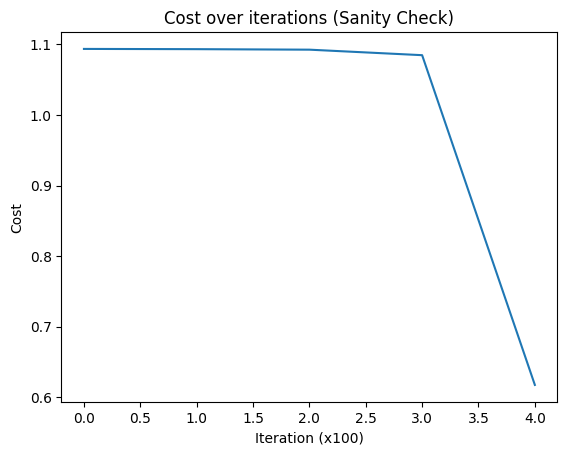

In [47]:
# === Sanity Check for l_layer_model + predict ===

np.random.seed(42)

# Fake data: 784 features, 3 classes, 50 examples
X_fake = np.random.randn(784, 50)
Y_labels = np.random.randint(0, 3, 50)

# One-hot encode labels
Y_fake = np.zeros((3, 50))
Y_fake[Y_labels, np.arange(50)] = 1

# Define simple network structure
layer_dims = [784, 20, 10, 3]  # 2 hidden layers + 3-class output

# Train model
parameters, costs = l_layer_model(X_fake, Y_fake, layer_dims, learning_rate=0.05, num_iterations=500, use_batchnorm=False)

# Predict
acc = predict(X_fake, Y_fake, parameters)
print(f"\n✅ Fake training accuracy: {acc * 100:.2f}%")

# Optional: plot cost

plt.plot(costs)
plt.title("Cost over iterations (Sanity Check)")
plt.xlabel("Iteration (x100)")
plt.ylabel("Cost")
plt.show()


**Part 4**

**Loading the MNIST Dataset**

In [62]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# 1. Load MNIST from OpenML
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.int64)

# 2. Normalize pixel values
X = X / 255.0  # shape: (70000, 784)

# 3. Train/val/test split (60k train, 10k test, and 10k from train for val)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=10000, random_state=42)

# 4. One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
Y_train = encoder.fit_transform(y_train.reshape(-1, 1)).T  # shape: (10, num_examples)
Y_val = encoder.transform(y_val.reshape(-1, 1)).T
Y_test = encoder.transform(y_test.reshape(-1, 1)).T

# 5. Transpose inputs to shape: (features, examples)
X_train = X_train.T  # shape: (784, num_examples)
X_val = X_val.T
X_test = X_test.T

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")


X_train shape: (784, 50000), Y_train shape: (10, 50000)
X_val shape: (784, 10000), Y_val shape: (10, 10000)
X_test shape: (784, 10000), Y_test shape: (10, 10000)


In [81]:
parameters, costs, val_accuracies, epochs, best_iter = l_layer_model(
    X_train, Y_train,
    #layer_dims=[784, 20, 7, 5, 10],
    layer_dims=[784, 64, 32, 16, 10], # Not sure is its allowed.
    learning_rate=0.009,
    num_iterations=10000,
    batch_size=256,
    use_batchnorm=False,
    X_val=X_val,
    Y_val=Y_val
)

print(f"Total epochs: {epochs:.2f}")
print(f"Best iteration: {best_iter}")



Iteration 100: Cost = 1.9028 | Val Acc = 39.26%
Iteration 200: Cost = 1.4118 | Val Acc = 60.81%
Iteration 300: Cost = 1.0447 | Val Acc = 76.09%
Iteration 400: Cost = 0.7501 | Val Acc = 83.07%
Iteration 500: Cost = 0.5952 | Val Acc = 84.89%
Iteration 600: Cost = 0.5637 | Val Acc = 86.31%
Iteration 700: Cost = 0.4485 | Val Acc = 87.37%
Iteration 800: Cost = 0.4400 | Val Acc = 87.95%
Iteration 900: Cost = 0.3841 | Val Acc = 88.65%
Iteration 1000: Cost = 0.2982 | Val Acc = 88.88%
Iteration 1100: Cost = 0.3261 | Val Acc = 89.42%
Iteration 1200: Cost = 0.3876 | Val Acc = 89.56%
Iteration 1300: Cost = 0.3795 | Val Acc = 89.83%
Iteration 1400: Cost = 0.2674 | Val Acc = 90.16%
Iteration 1500: Cost = 0.3060 | Val Acc = 90.30%
Iteration 1600: Cost = 0.2916 | Val Acc = 90.63%
Iteration 1700: Cost = 0.2262 | Val Acc = 90.79%
Iteration 1800: Cost = 0.2807 | Val Acc = 90.94%
Iteration 1900: Cost = 0.3011 | Val Acc = 91.21%
Iteration 2000: Cost = 0.3222 | Val Acc = 91.34%
Iteration 2100: Cost = 0.3113

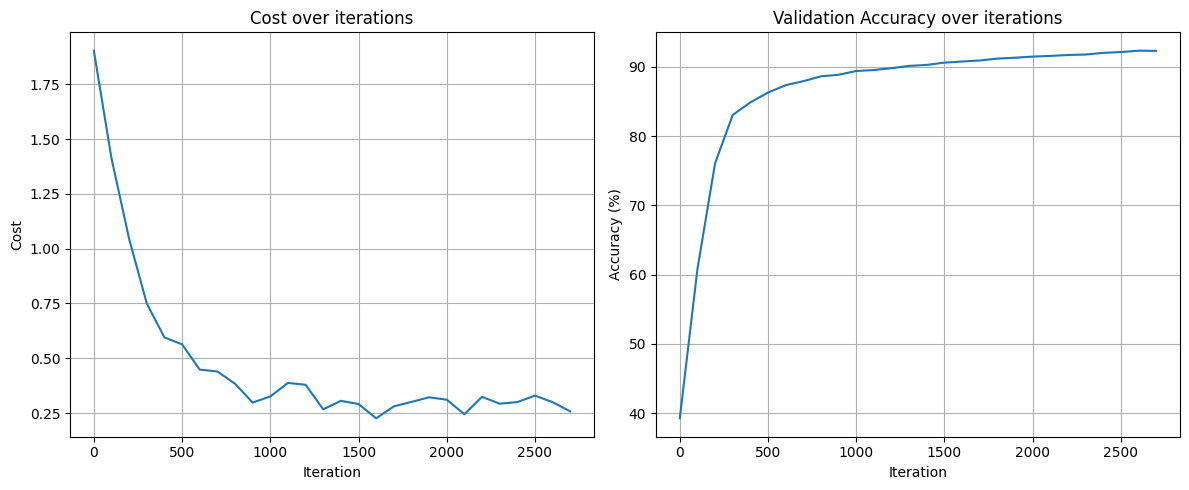

In [84]:
# Plot cost
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, len(costs)) * 100, costs)
plt.title("Cost over iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid()

# Plot val accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, len(val_accuracies)) * 100, np.array(val_accuracies) * 100)
plt.title("Validation Accuracy over iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.tight_layout()
plt.show()


In [85]:
def test_model(parameters, X_train, Y_train, X_val, Y_val, X_test, Y_test):
    train_acc = predict(X_train, Y_train, parameters)
    val_acc = predict(X_val, Y_val, parameters)
    test_acc = predict(X_test, Y_test, parameters)

    print(f"Final Accuracy Summary:")
    print(f"Train Accuracy:      {train_acc * 100:.2f}%")
    print(f"Validation Accuracy: {val_acc * 100:.2f}%")
    print(f"Test Accuracy:       {test_acc * 100:.2f}%")

    return train_acc, val_acc, test_acc


Final Accuracy Summary:
Train Accuracy:      92.66%
Validation Accuracy: 92.33%
Test Accuracy:       92.45%


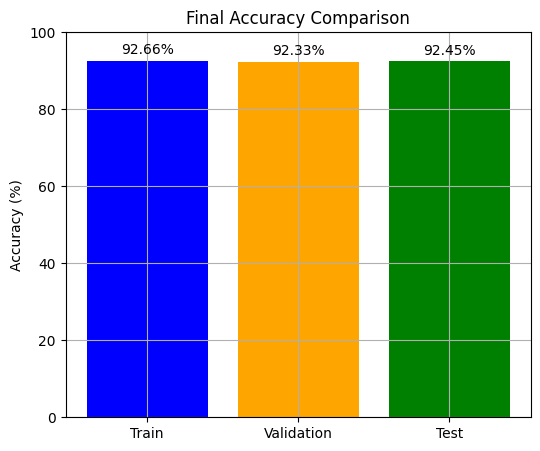

In [91]:
train_acc, val_acc, test_acc = test_model(parameters, X_train, Y_train, X_val, Y_val, X_test, Y_test)

# Bar plot of final accuracies
labels = ['Train', 'Validation', 'Test']
accuracies = [train_acc * 100, val_acc * 100, test_acc * 100]
colors = ['blue', 'orange', 'green']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, accuracies, color=colors)

# Add text labels above each bar
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f"{acc:.2f}%", ha='center', va='bottom', fontsize=10)

plt.title("Final Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.show()


**Part 5**